In [1]:
# INITIALIZATION CELL
#%load_ext autoreload
#%autoreload 2

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import math
import ipywidgets as widgets

from plot_helpers import *

import warnings
warnings.filterwarnings('ignore')
# %matplotlib qt5
%matplotlib inline
# %matplotlib widget

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
# plt.style.use(['ggplot'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [1.65, 1.25]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

############### Experiment selection ###################

# Obtain the list of experiments
EXP_list = [exp_folder.split('/')[-1] for exp_folder in sorted(glob.glob('%s/*' % datadir))]

# Obtain the mapping experiment -> configs
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir, exp)))] for exp in EXP_list}

# Obtain the mapping experiment/config -> reps
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir, exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

# Define all the widgets to be used
EXP_drop    = widgets.Dropdown(description='Exp:', options=EXP_list, value=EXP_list[-1], disabled=False)
EXP_mult    = widgets.SelectMultiple(description='Exp:', options=EXP_list, value=[EXP_list[-1]], disabled=False,)
CFG_drop    = widgets.Dropdown(description='Cfg:', options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:', options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

# Automatically default the dataset to most recently changed
recent = max([f"data/{EXP}" for EXP in EXP_list], key=os.path.getmtime).split('/')[-1]
EXP_drop.value = recent
EXP_mult.value = [recent]
print(f"last recorded dataset: {recent}")

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf, select = True):
    global df_exp
    global logfile
    global loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(3,2)
        grid[0,0] = EXP_drop
        grid[1,0] = CFG_drop
        grid[2,0] = REP_drop
        grid[1,1] = LOAD_button
        grid[2,1] = CONF_button
        display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df
def load_mult_df(datalog, select = True):
    global df_exp, logfile, loaded
    
    logfile = datalog
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(1,2)
        grid[0,0] = EXP_mult
        grid[0,1] = CONF_button
        display(grid)
        
        df = pd.DataFrame()
        for EXP in EXP_mult.value:
            df_exp = create_df(EXP, logfile)      
            df = pd.concat([df, df_exp], ignore_index=True)
            
    loaded = (EXP_mult.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
    return df

last recorded dataset: experiment_test


## (cluster+color boxplot) Precision vs #Byzantine

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Loaded || dataframe: experiment_short datafile: cluster
Loaded || dataframe: experiment_short datafile: color
Loaded || dataframe: experiment_short datafile: sc


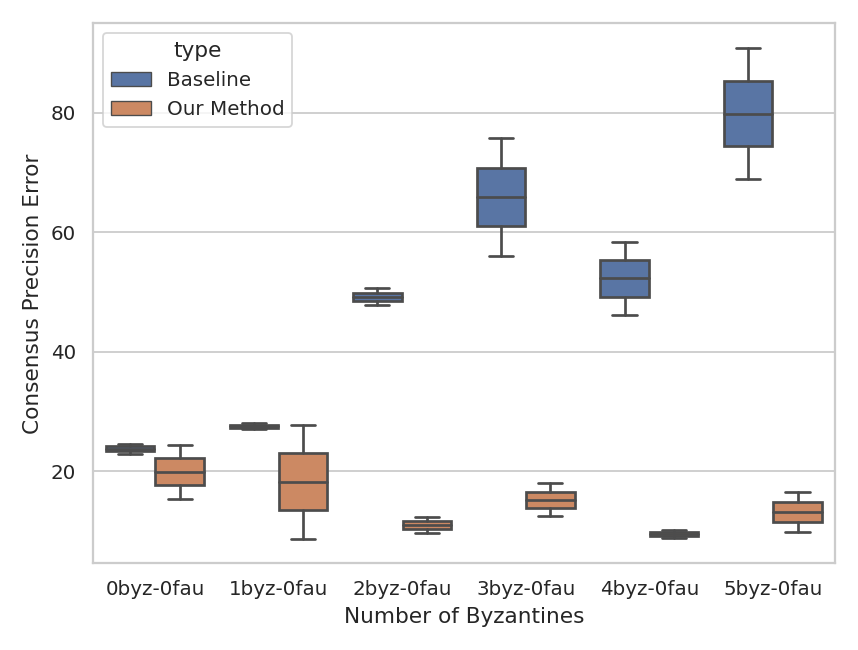

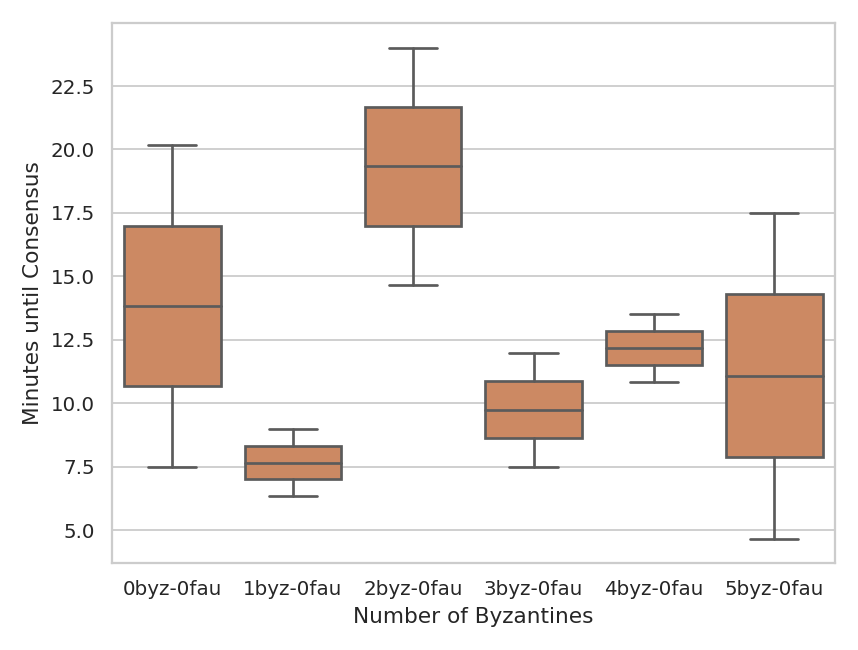

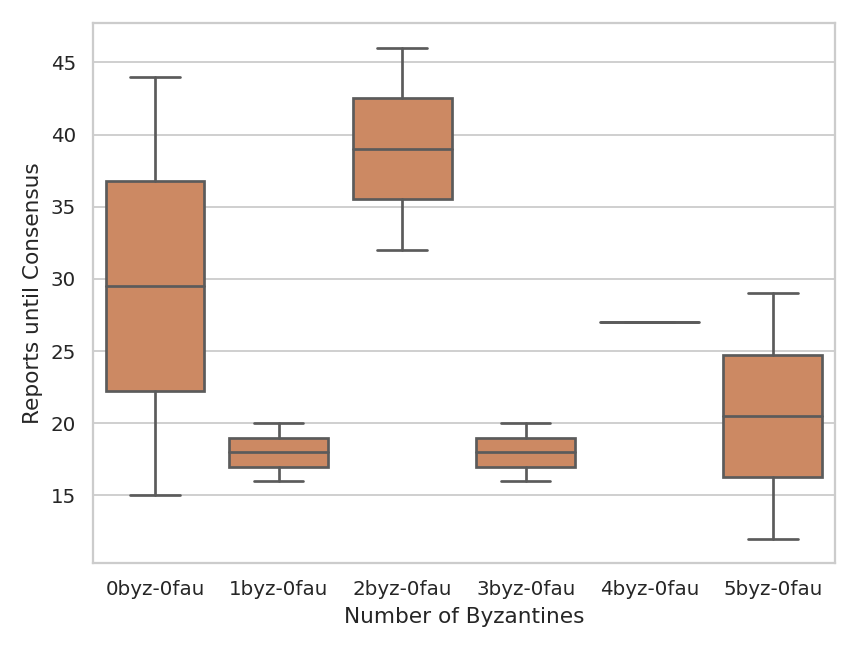

In [23]:
# Generate the dataframe
df_clust = load_df('cluster')
df_color = load_df('color', False)

# Plot options
XX = 'CFG'
YY = 'E'
yl = 'Consensus Precision Error'
xl = 'Number of Byzantines'
fs = double

# Corrections to dataframe
df_clust = df_clust.drop_duplicates('position').query('verified==1')
df_clust = df_clust.drop_duplicates(['CFG', 'REP'], keep='first')
df_clust['ID'] = df_clust['ID'].astype(int)
df_clust['B'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)

df_avg_red = df_color.query('IDX==0')[['B', 'G', 'R']].mean()
df_color = df_color.query('FOOD').reset_index()

df = pd.concat([df_color[['B', 'G', 'R','CFG', 'REP']], df_clust[['B', 'G', 'R','block_verified','CFG', 'REP']]], keys=['Baseline', 'Our Method'])
df[['_B','_G','_R']] = df_avg_red
df['E'] = df.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)
df.reset_index(level=0, inplace=True)
df.rename(columns={'level_0': 'type'}, inplace=True)
df['min_verified'] = df['block_verified'] * 10 / 60

#################
# Create plot 1
fig, ax = plt.figure(figsize=fs), plt.axes()
sns.set(style='whitegrid')

# df = df[df['CFG']=='0byz-0fau'
grouped = df.groupby(['type', 'CFG', 'REP'], as_index=False).agg({YY:'mean'})
sns.boxplot(data=grouped, x=XX, y=YY, hue='type', dodge=True)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 40)
# ax.set_title('Balance at end of experiment')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

################
# Plot options
XX = 'CFG'
YY = 'min_verified'
yl = 'Minutes until Consensus'
xl = 'Number of Byzantines'
fs = double

# Create plot 2
fig, ax = plt.figure(figsize=fs), plt.axes()
sns.set(style='whitegrid')

grouped = df.groupby(['type', 'CFG', 'REP'], as_index=False).agg({YY:'mean'})
sns.boxplot(data=grouped, x='CFG', y=YY,color=sns.color_palette()[1], dodge=True)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 100)
# ax.set_title('Balance at end of experiment')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

# ################
# df_tx = load_df('tx', False)

# df_tx = df_tx[df_tx['MINED?']=="Yes"]
# df_tx = df_tx[df_tx['STATUS']=="1"]
# df_tx['BLOCK'] = df_tx['BLOCK'].astype('int')
# # df_tx['NONCE'] = df_tx['NONCE']+1
# df_tx = df_tx.merge(df_clust[['CFG', 'REP', 'block_verified']], on=['CFG', 'REP'], how='left')
# df_tx = df_tx.query('BLOCK<block_verified')

# df = df_tx[['CFG', 'REP']].value_counts().reset_index()

# df['count'] = df['count'].astype('int')
# # new_row_data = {col: np.nan if col != "CFG" else "0byz-0fau" for col in df.columns}
# # df.loc[len(df.index)] = new_row_data
# # df = df.sort_values(by='CFG')

# # Plot options
# XX = 'CFG'
# YY = 'count'
# yl = 'Reports until Consensus'
# xl = 'Number of Byzantines'
# fs = double

# # Create plot 3
# fig, ax = plt.figure(figsize=fs), plt.axes()
# sns.set(style='whitegrid')

# # grouped = df_tx.groupby(['CFG', 'REP'], as_index=False).agg({YY:'mean'})
# sns.boxplot(data=df, x='CFG', y=YY, color=sns.color_palette()[1], dodge=True)

# # Set the labels
# ax.set_xlabel(xl)
# ax.set_ylabel(yl)
# ax.set_title('') 
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))
# # ax.set_ylim(ymin=0, ymax = 100)
# # ax.set_title('Balance at end of experiment')
# plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# # plt.show()


################
df_t = df_clust[['CFG', 'REP', 'block_verified']]
df_sc = load_df('sc', False)
df_sc = df_sc.drop_duplicates('HASH')
merged_df = df_t.merge(df_sc, on=['CFG', 'REP'])
result_df = merged_df[merged_df['BLOCK'] == merged_df['block_verified']]
result_df = result_df.drop_duplicates(['CFG', 'REP'], keep='first')

# Plot options
XX = 'CFG'
YY = 'RS1'
yl = 'Reports until Consensus'
xl = 'Number of Byzantines'
fs = double

# Create plot 3
fig, ax = plt.figure(figsize=fs), plt.axes()
sns.set(style='whitegrid')

# grouped = df_tx.groupby(['CFG', 'REP'], as_index=False).agg({YY:'mean'})
sns.boxplot(data=result_df, x='CFG', y=YY, color=sns.color_palette()[1], dodge=True)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))
# ax.set_ylim(ymin=0, ymax = 100)
# ax.set_title('Balance at end of experiment')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

## (extra timeplot) Memory/RAM/CPU

GridspecLayout(children=(Dropdown(description='Exp:', index=5, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: short datafile: extra


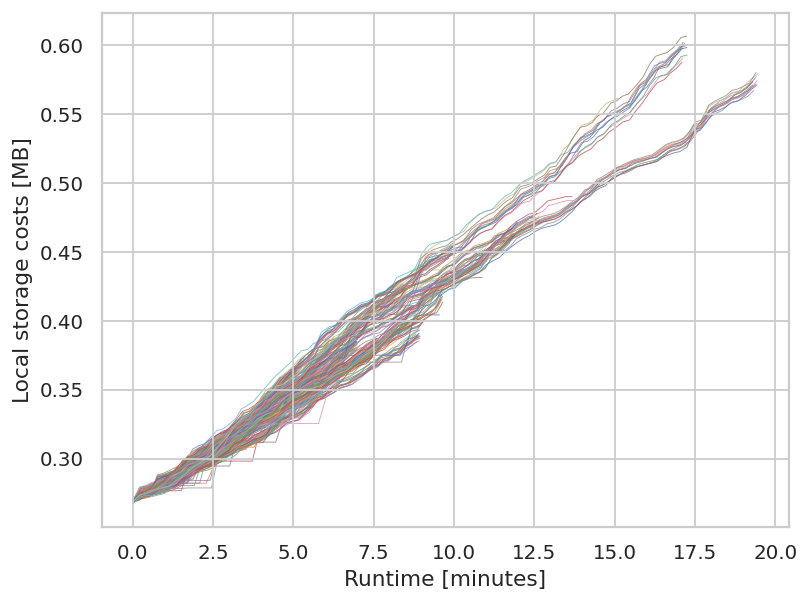

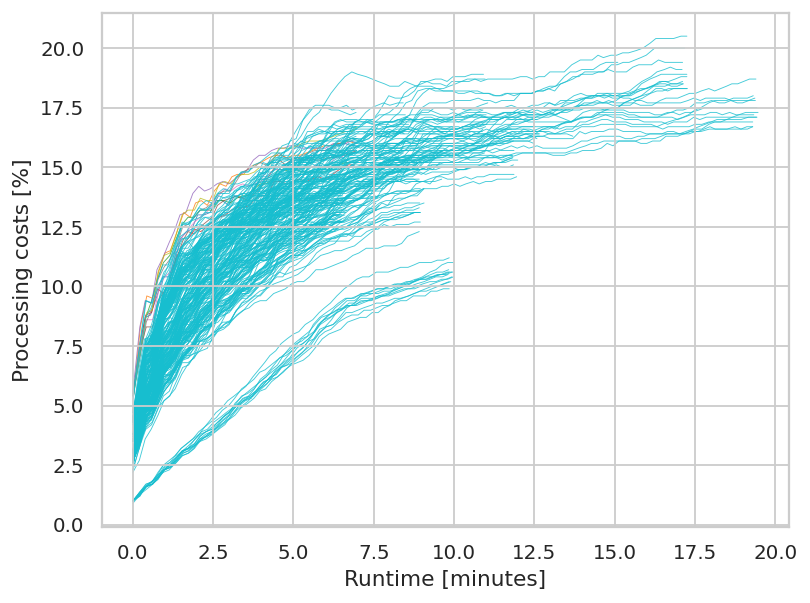

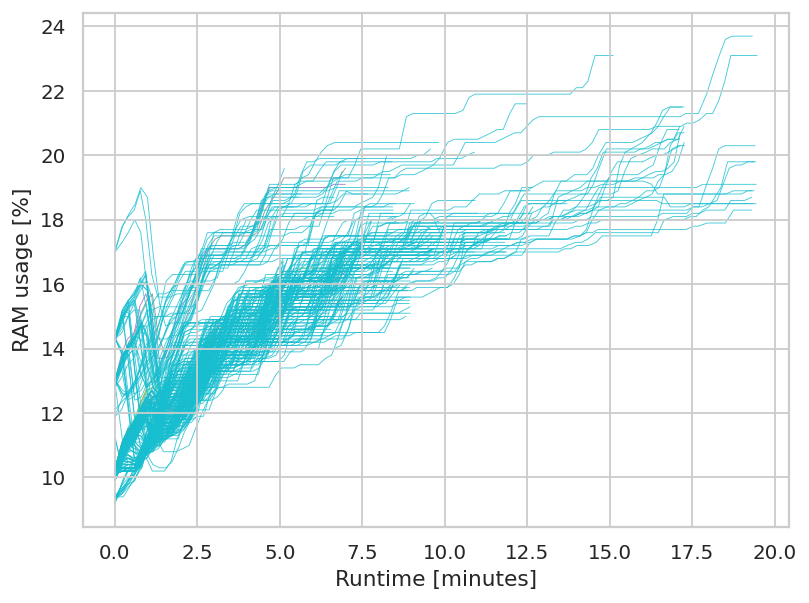

In [74]:
# Generate the dataframe
df = load_df('extra')

df['TIME_M'] = df['TIME'].round().astype(int) /60
# df['MB'] = df['CHAINDATASIZE'].fillna(df['MEM'])/1e6
df['MB'] = df['MEM']/1e6

# df = df.query('REP == "001"')
# display(df)
# Process the dataframe  
# df = df.groupby(['Robots']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# display(df[['Robots','MB']])
# Create plot

# display(df)
# df = df[['Robots','TIME_M','MB']]
# display(df.groupby(['Robots', 'TIME_M'], as_index=False).mean().set_index('TIME_M')['MB'])

# df.groupby(['REP'], as_index=False).mean().set_index('TIME)['MB'].plot(ax=ax)

# df.groupby('Robots').boxplot(column='MB', by='TIME_MR', figsize=double)
# sns.boxplot(x=df['TIME_MR'], y=df['MB'], hue=df['Robots'], showfliers = False)

# display(df)
# s = df.pivot('TIME_M', 'ID', 'MB').mean(axis=1).resample('0.15S').mean()

# display(df)
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP')['MB'].transform(lambda x: x.rolling(10, 1).mean())
# df['MB_mov_avg'] = df.set_index(['TIME']).groupby('REP').rolling(10)['CHAINDATASIZE'].mean().reset_index(drop=True)
# display(df)
# s.plot(ax = ax, figsize = double)
# display(df)
ax = plt.axes()
df.set_index(['TIME_M']).groupby(['CFG','REP','ID'])['MB'].plot(ax = ax, label='_nolegend_', linewidth=0.5, alpha = 0.8, zorder=0)

# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

i=0
color_map = plt.get_cmap('tab10')
fig, ax = plt.subplots()
for rep_value, rep_data in df.set_index(['TIME_M']).groupby(['CFG', 'REP', 'ID'])['%CPU']:
    rep_data.plot(ax=ax, label=rep_value, color=color_map(i), linewidth=0.5, alpha=0.8, zorder=0)
    i+=1
# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Processing costs [%]')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()


i=0
color_map = plt.get_cmap('tab10')
fig, ax = plt.subplots()
for rep_value, rep_data in df.set_index(['TIME_M']).groupby(['CFG', 'REP', 'ID'])['%RAM']:
    rep_data.plot(ax=ax, label=rep_value, color=color_map(i), linewidth=0.5, alpha=0.8, zorder=0)
    i+=1
# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('RAM usage [%]')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

## (sc boxplot) Balance vs Robot

In [3]:
%matplotlib inline

# Generate the dataframe
df = load_df('sc')
display(df)
# For short runs:
df = df[df['#ACCEPT']==1]
df = df.drop_duplicates(['ID', 'CFG', 'REP','isbyz'], keep='first')

# Plot options
XX = 'ID'
YY = 'BALANCE'
yl = 'Balance'
xl = 'Is Byzantine'
fs = double

# Corrections to dataframe
df['ID'] = df['ID'].astype(int)

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()
sns.set(style='whitegrid')

name_colors = {True: 'red', False: 'blue'}
grouped = df.groupby(['ID', 'REP', 'isbyz'], as_index=False).agg({YY:'last'})
sns.boxplot(data=grouped, x='ID', y=YY, hue='isbyz', palette=name_colors, dodge=False)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 50)
ax.set_title('Balance at end of experiment')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Loaded || dataframe: experiment_short datafile: sc


,ID,TIME,BLOCK,HASH,BALANCE,SPENDABLE,PENDING,#CLUSTERS,#ACCEPT,#REJECT,#PENDING,RS1,RS2,RS3,RS4,EXP,CFG,REP
0,1,0.292,0,0x7e865e3743439b5428f028920065d4f1dde951dd4e88...,21.00,21.00000,0,0,0,0,0,0,0,0,0,experiment_short,0byz-0fau,001
1,1,8.603,1,0x859ca1ce404009a99966f6aa9a5c8400985d9bbd7c62...,21.00,21.00000,0,0,0,0,0,0,0,0,0,experiment_short,0byz-0fau,001
2,1,9.127,1,0x2fdc644352c27550a1e04e982bb741160fe432d374d2...,21.00,21.00000,0,0,0,0,0,0,0,0,0,experiment_short,0byz-0fau,001
3,1,17.699,2,0x7bd9be16e49a19ecc8290cf2cb1ee33e8b2520389cbf...,21.00,21.00000,0,0,0,0,0,0,0,0,0,experiment_short,0byz-0fau,001
4,1,27.813,3,0x16c38463bc1efabdd0c1888094de3beb6007cd90312e...,21.00,21.00000,0,0,0,0,0,0,0,0,0,experiment_short,0byz-0fau,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,9,808.515,72,0xe9e9c7cd08e612a53bbaf70e3f7c496e704d73fbee9e...,22.26,15.17231,0,5,1,2,2,33,6,12,0,experiment_short,2byz-0fau,001
1969,9,809.308,72,0x3507c353ec919ef123d50f6437054b4bd3fb64d99dd8...,22.26,15.17231,0,5,1,2,2,34,6,12,0,experiment_short,2byz-0fau,001
1970,9,818.395,73,0x3bf3ed04eef067a5d4e9f7bde3decbe6b1ab0ebee3ff...,22.26,15.17231,0,5,1,2,2,34,6,13,0,experiment_short,2byz-0fau,001
1971,9,828.748,74,0x2ab8da30cecef7096b0ea192499d7f471654ea4d1168...,22.26,15.17231,0,5,1,2,2,34,6,13,0,experiment_short,2byz-0fau,001


KeyError: Index(['isbyz'], dtype='object')

## (sc timeplot) Balance vs Block

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Loaded || dataframe: experiment_short datafile: block
Loaded || dataframe: experiment_short datafile: sc


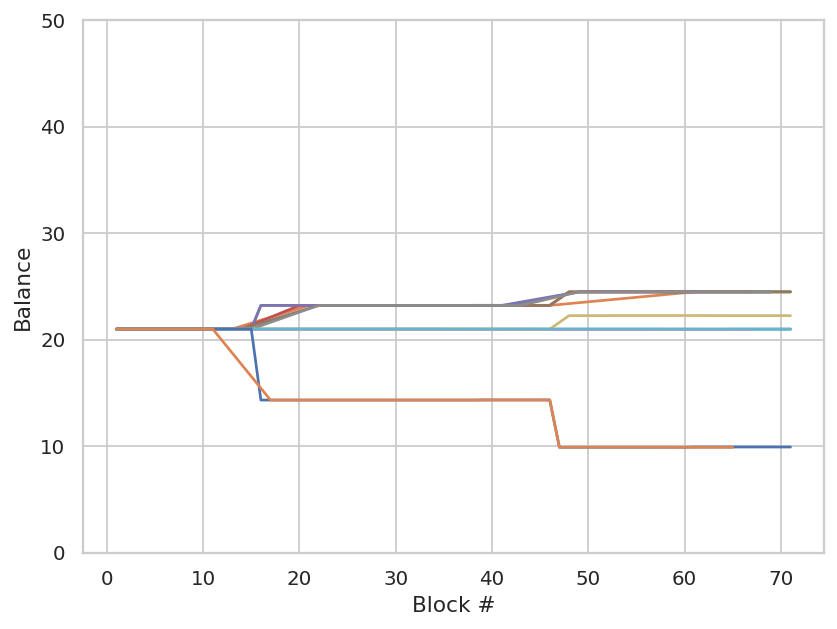

In [4]:
# Get the mainchain
df = load_df('block')

# Process data
mainchains = []
for name, group in df.groupby('REP'):
    group = group.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
    group = trim_chain(group, 3).reset_index()
    main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]

    # Iterate from main_leaf to genesis -> mainchain
    df_mainchain = get_mainchain_df(group, main_leaf)
    mainchains += list(df_mainchain['HASH'])

# Generate the dataframe
df = load_df('sc', False)

# Plot options
XX = 'TIME'
YY = 'BALANCE'
yl = 'Balance'
xl = 'Block #'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Group by 'REP' and 'ID', and get the last value of 'YY'
df = df[df['HASH'].isin(mainchains)]
df = df.set_index('BLOCK')
# df = df.query('ID == 107')
df.groupby(['REP', 'ID'])[YY].plot()



# for name, group in df.groupby('isbyz'):
#     isbyz = name
#     if isbyz:
#         sns.lineplot(data=group, x='BLOCK', y=YY, ax=ax, color='red', label='Byzantine')
#         # group.groupby(['REP', 'ID'])[YY].plot(color='red', alpha=0.1, linewidth=0.75, label=None)
#         # group.groupby(['BLOCK'])[YY].mean().plot(color='red', alpha=1, linewidth=1, label='Byzantine')
        
#     else:
#         sns.lineplot(data=group, x='BLOCK', drawstyle='steps', y=YY, ax=ax, color='blue', label='Honest')
#         # group.groupby(['REP', 'ID'])[YY].plot(color='blue', alpha=0.1, linewidth=0.75, label=None)
#         # group.groupby(['BLOCK'])[YY].mean().plot(color='blue', alpha=1, linewidth=1, label='Honest')

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 50)
# Filter handles and labels based on line width
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles = [h for h in handles if h.get_linewidth() == 1]
filtered_labels = [l for h, l in zip(handles, labels) if h.get_linewidth() == 1]

# Display the modified legend
# plt.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## (tx timeplot) Transactions vs block

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('short', …

Loaded || dataframe: short datafile: tx
Loaded || dataframe: short datafile: color


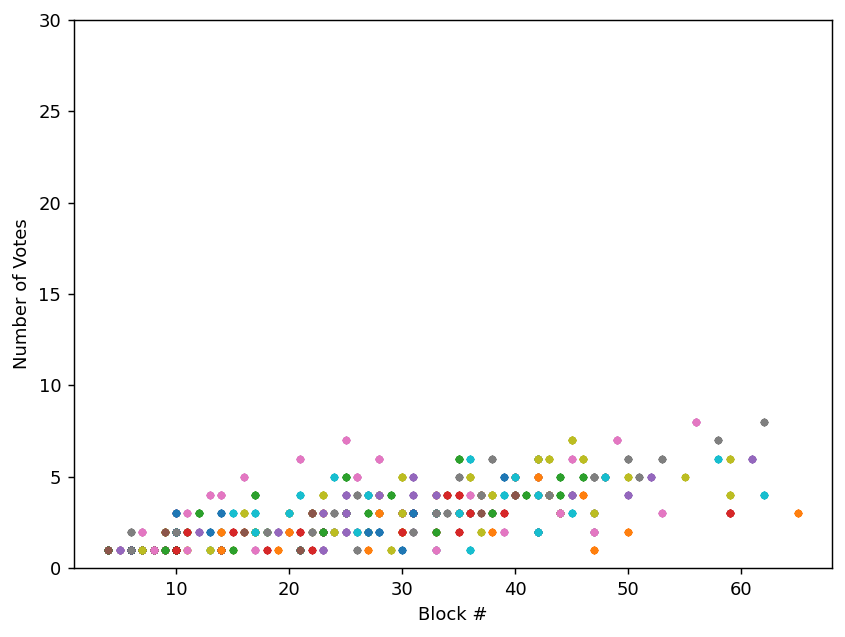

In [6]:
# Create dataframe
df = load_df('tx')

df = df[df['MINED?']=="Yes"]
df['NONCE'] = df['NONCE']+1
df['BLOCK'] = df['BLOCK'].astype('int')

df_temp = load_df('color', False)[['ID','REP','isbyz']]
df = df.merge(df_temp, on=['ID','REP'])
# df['isbyz'] = df['isbyz_y']

# Plot optionsmainchains
XX = 'BLOCK'
YY = 'NONCE'
yl = 'Number of Votes'
xl = 'Block #'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Plot the number of report for each robot
df.set_index(XX).groupby(['REP','CFG','ID'])[YY].plot(style = '.', ax=ax)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)
# plt.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

# # Create plot
# fig, ax = plt.figure(figsize=fs), plt.axes()

# # Group by 'REP' and 'ID', and get the last value of 'YY'
# name_colors = {True: 'red', False: 'blue'}
# df = df.groupby(['ID', 'REP','isbyz'], as_index=False).agg({YY:'max'})
# df = df[df['isbyz']==False]
# sns.boxplot(ax=ax, data=df, x='ID', y=YY, hue='isbyz', palette=name_colors, dodge=False)

# # # Adjust x-axis limits and ticks
# # plt.xlim(min(df[XX]) - 1, max(df[XX]) + 1)
# # plt.xticks(range(min(df[XX]), max(df[XX]) + 1))

# # Set the labelsmainchains
# ax.set_xlabel(xl)
# ax.set_ylabel(yl)
# ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# plt.legend()
# plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

## (cluster timeplot) Clusters vs Block

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Loaded || dataframe: experiment_short datafile: block
Loaded || dataframe: experiment_short datafile: sc


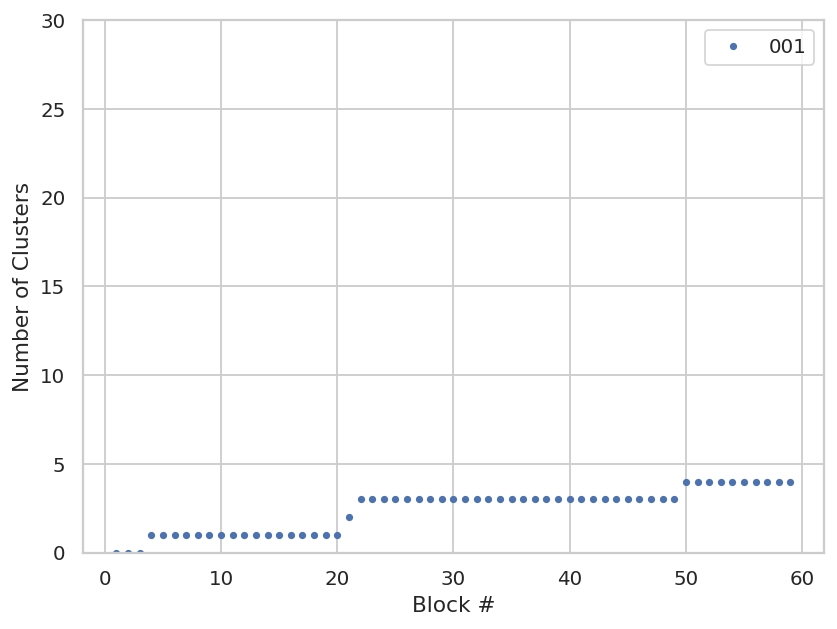

In [5]:
# Get the mainchain
df = load_df('block')

# Process data
mainchains = []
for name, group in df.groupby('REP'):
    group = group.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
    group = trim_chain(group, 15).reset_index()
    main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]

    # Iterate from main_leaf to genesis -> mainchain
    df_mainchain = get_mainchain_df(group, main_leaf)
    mainchains += list(df_mainchain['HASH'])

# Generate the dataframe
df = load_df('sc', False)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()

# Plot options
XX = 'BLOCK'
YY = '#CLUSTERS'
yl = 'Number of Clusters'
xl = 'Block #'
fs = double


# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Group by 'REP' and 'ID', and get the last value of 'YY'
df = df.set_index(XX)
df.groupby(['REP'])[YY].plot(style = '.')

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)
plt.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## (color + sc 3dplot) Points and Clusters 

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Loaded || dataframe: experiment_short datafile: color
Loaded || dataframe: experiment_short datafile: cluster
False negatives: 0/16
False positives: 0/10
Loaded || dataframe: experiment_short datafile: color
False negatives: 104/521
False positives: 78/369


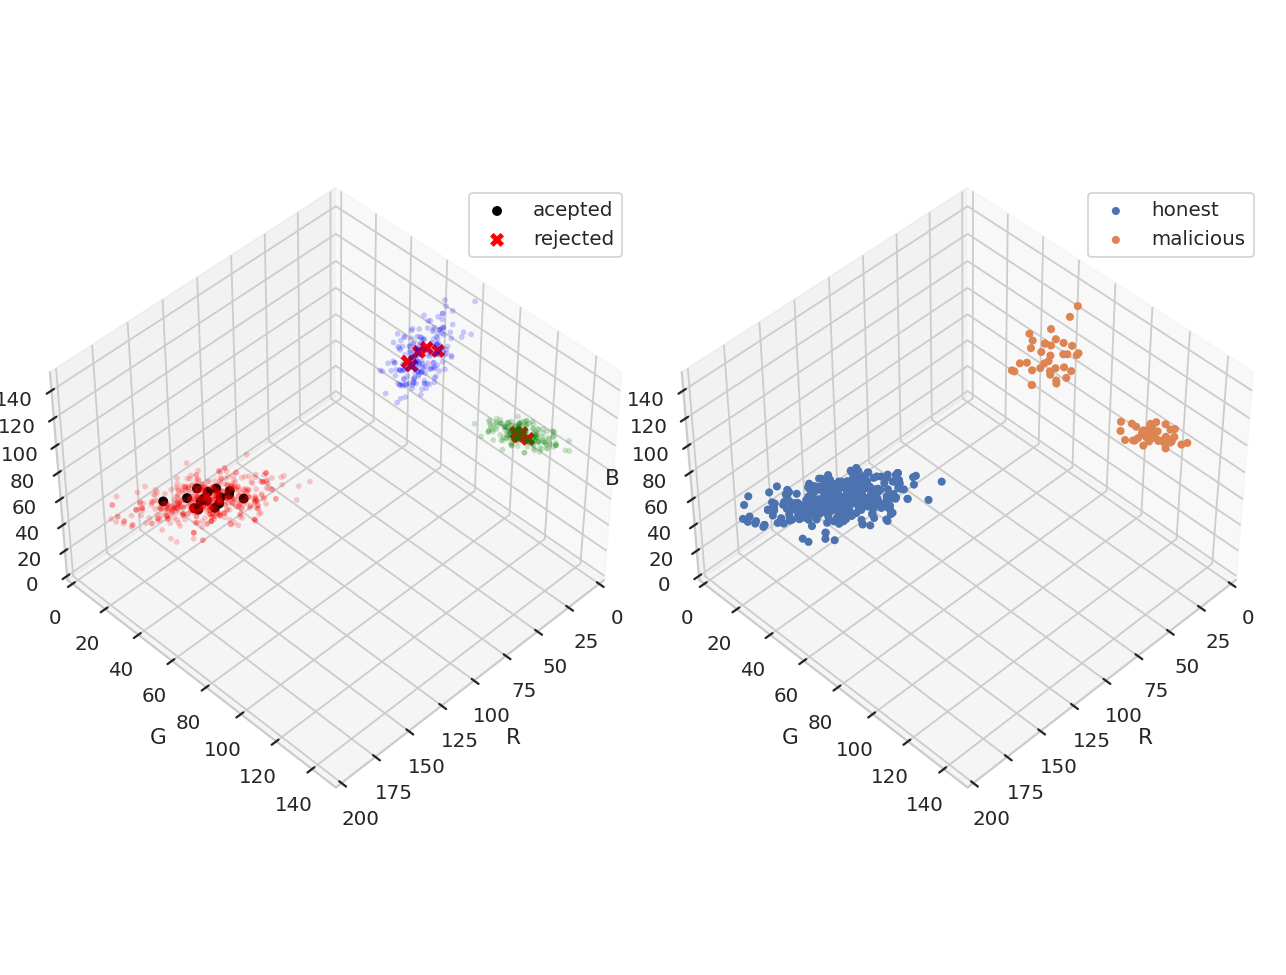

In [6]:
%matplotlib widget

# Create dataframe
df = load_df('color')

# Create a 3D plot
fig = plt.figure(figsize = 1.5*double)
ax = fig.add_subplot(121, projection='3d')
for name, group in df.groupby('NAME'):
    ax.scatter(group['R'], group['G'], group['B'], color=name, alpha=0.2, s=10, edgecolors='none')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.gcf().tight_layout()
ax.set_xlim([0,200])
ax.set_ylim([0,150])
ax.set_zlim([0,150])

df = load_df('cluster', select = False)
df = df.drop_duplicates('position')
df['B'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df['G'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df['R'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)

dfa = df.query('verified==1')
ax.scatter(dfa['R'], dfa['G'], dfa['B'], color='black', alpha=1.0, marker='o', s=30, edgecolors='none', label='acepted')

dfr = df.query('verified==2')
ax.scatter(dfr['R'], dfr['G'], dfr['B'], color='red', alpha=1.0, marker='X', s=60, edgecolors='none', label='rejected')
ax.legend()
ax.view_init(elev=45, azim=45)

total_acepted_clusters = len(df.query('verified==1'))
print(f'False negatives: {0}/{total_acepted_clusters}')

total_rejected_clusters = len(df.query('verified==2'))
print(f'False positives: {0}/{total_rejected_clusters}')

df = load_df('color', select = False)
ax = fig.add_subplot(122, projection='3d')
# df_unique = df[['ID', 'isbyz']].drop_duplicates()
# print(df_unique)

df['FOOD'] = df['FOOD'].astype(bool)
df['isfau']= df['isfau'].astype(bool)
df['isbyz'] = df['isbyz'].astype(bool)

for name, group in df.query('FOOD').groupby('type'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=1, edgecolors='none', label=name)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_xlim([0,200])
ax.set_ylim([0,150])
ax.set_zlim([0,150])
ax.legend()
ax.view_init(elev=45, azim=45)
plt.gcf().tight_layout()

total_food = len(df.query('NAME=="red"'))
false_negatives = len(df.query('NAME=="red" and not FOOD'))
print(f'False negatives: {false_negatives}/{total_food}')

total_notfood = len(df.query('NAME in ["green","blue"]'))
false_positives = len(df.query('NAME in ["green","blue"] and FOOD'))
print(f'False positives: {false_positives}/{total_notfood}')

## (color boxplot) Color perception vs ID

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('experime…

Text(0.5, 1.0, 'Boxplot of YY by ID and NAME')

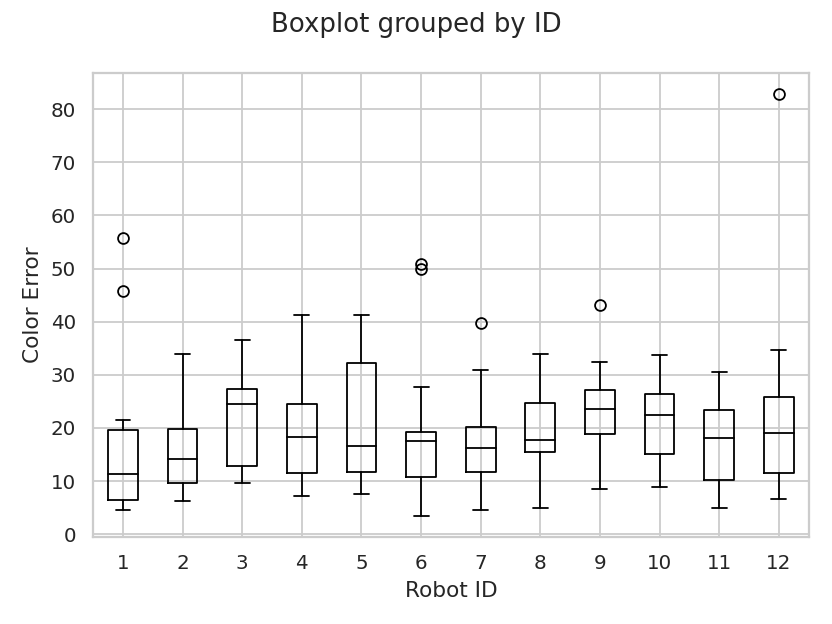

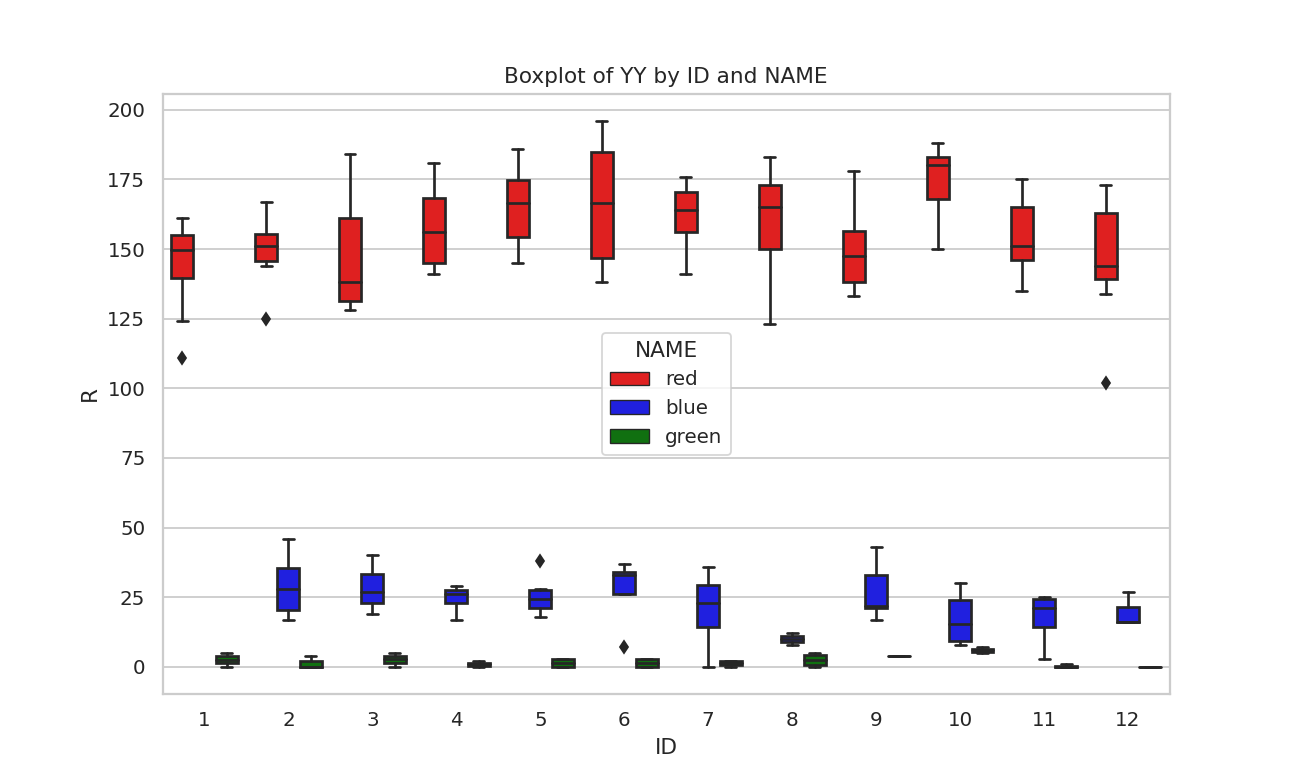

In [8]:
df = load_df('color')
df_avg = df.groupby('NAME')[['R','G','B']].agg('mean')

df['ER'] = df.apply(lambda row: (row['R']-df_avg.loc[row['NAME']]['R']), axis=1)
df['EG'] = df.apply(lambda row: (row['G']-df_avg.loc[row['NAME']]['G']), axis=1)
df['EB'] = df.apply(lambda row: (row['B']-df_avg.loc[row['NAME']]['B']), axis=1)
df['E'] = df.apply(lambda row: math.sqrt(row['ER']**2+row['EG']**2+row['EB']**2), axis=1)

# Plot options
XX = 'ID'
YY = 'E'
yl = 'Color Error'
xl = 'Robot ID'
fs = double

# Corrections to dataframe
df['ID'] = df['ID'].astype(int)

# Create plot
fig, ax = plt.subplots()

# Group by 'REP' and 'ID', and get the last value of 'YY'
grouped = df.groupby(['ID'])[YY]

df.boxplot(column=YY, by='ID', ax=ax, color='black')

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 

plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

name_colors = {'red': 'red', 'blue': 'blue', 'green': 'green'}
sns.boxplot(data=df, x='ID', y='R', hue='NAME', palette=name_colors)

ax.set_xlabel(xl)
ax.set_ylabel(yl)
plt.title('Boxplot of YY by ID and NAME')

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()